In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [2]:
print(tf.__version__)

2.10.0


In [3]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    # validation_split=0.2, 
    # subset='training', 
    seed=seed)

Found 44307 files belonging to 2 classes.


In [4]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b"ORIGINAL TWEET CONTENT : obama confidante <person> <person> moved into his washington home to mastermind insurgency against hashtag ! it's called hashtag ! urlREPORTED TWEET CONTENT:@user fake news url url "
Label 0
Review b'ORIGINAL TWEET CONTENT : @user is it b c of " priveledge michelle\'s mom will get $ <number> for life ? what do you consider that ? who gets pd for being a g-ma ?REPORTED TWEET CONTENT:@user as <person> would say ... wrong url ORIGINAL TWEET CONTENT : @user $ <number> for life ; for being a grandma ?REPORTED TWEET CONTENT:@user as <person> would say ... wrong url '
Label 0
Review b'ORIGINAL TWEET CONTENT : hashtag this has to stop ! antifa = terrorists urlREPORTED TWEET CONTENT:@user sorry gurl url '
Label 0


In [5]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to false
Label 1 corresponds to true


In [6]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'val',
    batch_size=batch_size, 
    # validation_split=0.2, 
    # subset='validation', 
    seed=seed)

Found 6149 files belonging to 2 classes.


In [7]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)

Found 6183 files belonging to 2 classes.


In [8]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [9]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [10]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [11]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [12]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"ORIGINAL TWEET CONTENT : @user tell it like it is sheriff ! ! !REPORTED TWEET CONTENT:@user it's a lie . url ORIGINAL TWEET CONTENT : the united states has the highest corporate tax rate of any developed country in the world . hashtagREPORTED TWEET CONTENT:@user jfc just read a little . url ORIGINAL TWEET CONTENT : @user urlREPORTED TWEET CONTENT:@user this meme is bullshit . omg . the world is full of dotards ! even url ORIGINAL TWEET CONTENT : @user national voter registration act of <number> ( nvra ) ( <number> u . s . c . <number> ) ( formerly <number> u . s . c . <number> - <number> ) do better researchREPORTED TWEET CONTENT:@user and this url ORIGINAL TWEET CONTENT : lying lib media spreads fake news about me and @user to fool their liberal followers into believing lies because as <person> . bill <person> once said , look , the average democrat voter is just plain stupid . theyre easy to manipulate . classic ! urlREPORTED TWEET CONTENT:@user i think you are the

In [13]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  water
 313 --->  flag
Vocabulary size: 10000


In [14]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
embedding_dim = 16

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])


In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [19]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


C:\Users\shrey\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1385/1385 [==============================] - 16s 11ms/step - loss: 0.5747 - accuracy: 0.7767 - val_loss: 0.4970 - val_accuracy: 0.7931
Epoch 2/10
1385/1385 [==============================] - 9s 6ms/step - loss: 0.5037 - accuracy: 0.7772 - val_loss: 0.4784 - val_accuracy: 0.7931
Epoch 3/10
1385/1385 [==============================] - 9s 6ms/step - loss: 0.4873 - accuracy: 0.7782 - val_loss: 0.4630 - val_accuracy: 0.7948
Epoch 4/10
1385/1385 [==============================] - 9s 6ms/step - loss: 0.4701 - accuracy: 0.7809 - val_loss: 0.4466 - val_accuracy: 0.7972
Epoch 5/10
1385/1385 [==============================] - 9s 6ms/step - loss: 0.4518 - accuracy: 0.7832 - val_loss: 0.4295 - val_accuracy: 0.8013
Epoch 6/10
1385/1385 [==============================] - 9s 6ms/step - loss: 0.4331 - accuracy: 0.7896 - val_loss: 0.4127 - val_accuracy: 0.8070
Epoch 7/10
1385/1385 [==============================] - 9s 6ms/step - loss: 0.4152 - accuracy: 0.8007 - val_loss: 0.3971 - val_accuracy: 0.8187
E

In [20]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

194/194 [==============================] - 1s 7ms/step - loss: 0.3528 - accuracy: 0.8502
Loss:  0.35278987884521484
Accuracy:  0.8502345085144043


In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

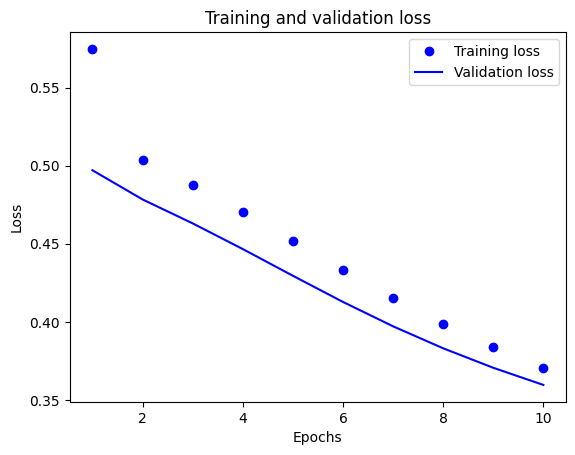

In [22]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()